# Convolutional Neural Networks: comparison of the performances of different CNN architectures on chest x-ray images

The dataset used in this notebook contains 5783 chest X-ray images of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. The dataset can be found here:
https://data.mendeley.com/datasets/rscbjbr9sj/2

The goal is to create a model that given a new chest X-ray image, it predicts whether the patient has pneumonia or not.

In this notebook, the performance of 4 different CNN architectures are compared:
* Simple CNN with 5 convolutional layers
* AlexNet
* Transfer learning using VGG-16
* Transfer learning using DenseNet121

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from skimage.color import rgb2gray
%matplotlib inline

In [2]:
#For Kaggle
!conda install -y gdown
import gdown
url = "https://drive.google.com/uc?export=download&id=1Eo0rmraRTm9YsYUSngGPk88p72Bgct2A"
output = "17810_23812_bundle_archive.zip"
gdown.download(url, output, quiet=False)

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.8.5                |   py37hc8dfbb8_1         3.0 MB  conda-forge
    gdown-3.12.2               |     pyh9f0ad1d_0          12 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.1 MB

The following NEW packages will be INSTALLED:

  gdown              conda-forge/noarch::gdown-3.12.2-pyh9f0ad1d_0

The following packages will be UPDATED:

  conda                                4.8.4-py37hc8dfbb8_2 --> 4.8.5-py37hc8dfbb8_1



gdown-3.12.2         | 12 KB     | ##################################### | 100% 
conda-4.8.5          | 3.0 MB    | ##################################### | 100% 
Preparing transaction: done
Verifying tra

Downloading...
From: https://drive.google.com/uc?export=download&id=1Eo0rmraRTm9YsYUSngGPk88p72Bgct2A
To: /kaggle/working/17810_23812_bundle_archive.zip
2.46GB [00:28, 85.4MB/s]


'17810_23812_bundle_archive.zip'

In [ ]:
#For Google Colab
from google.colab import drive
drive.mount('/content/drive')

In [3]:
import zipfile

#For Google Colab:
#with zipfile.ZipFile('drive/My Drive/17810_23812_bundle_archive.zip','r') as z:
#  z.extractall('.')

#For Kaggle:
with zipfile.ZipFile('17810_23812_bundle_archive.zip','r') as z:
  z.extractall('.')

In [4]:
os.remove('17810_23812_bundle_archive.zip') #For kaggle

In [5]:
os.listdir('./chest_xray')

['val', 'test', 'train', 'chest_xray', '__MACOSX']

In [6]:
train_path = './chest_xray/train/'
test_path = './chest_xray/test/'
val_path = './chest_xray/val/'

In [7]:
os.listdir(train_path)

['NORMAL', 'PNEUMONIA']

In [8]:
os.listdir(train_path+'NORMAL')[0:10]

['IM-0218-0001.jpeg',
 'IM-0241-0001.jpeg',
 'IM-0469-0001.jpeg',
 'IM-0532-0001.jpeg',
 'IM-0525-0001.jpeg',
 'NORMAL2-IM-0939-0001.jpeg',
 'NORMAL2-IM-1292-0001.jpeg',
 'IM-0183-0001.jpeg',
 'NORMAL2-IM-0744-0001.jpeg',
 'NORMAL2-IM-0545-0001.jpeg']

In [9]:
os.listdir(train_path+'PNEUMONIA')[0:10]

['person993_virus_1671.jpeg',
 'person278_virus_574.jpeg',
 'person823_virus_1459.jpeg',
 'person775_virus_1404.jpeg',
 'person1129_bacteria_3070.jpeg',
 'person1405_bacteria_3567.jpeg',
 'person1441_virus_2457.jpeg',
 'person264_bacteria_1230.jpeg',
 'person626_virus_1202.jpeg',
 'person1484_bacteria_3878.jpeg']

### Let's visualize a few images

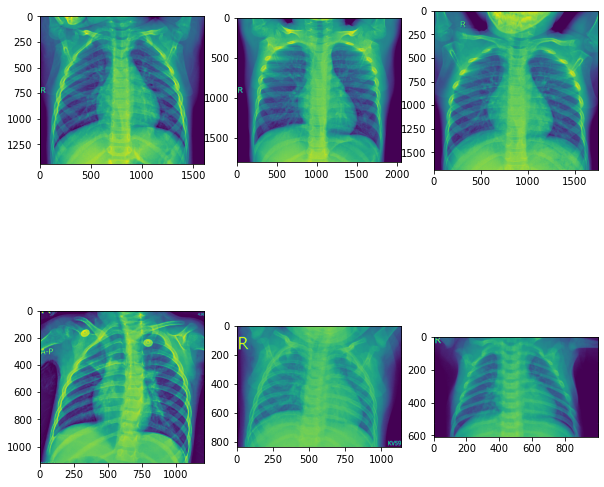

In [10]:
normal_1 = train_path+'NORMAL/NORMAL2-IM-1142-0001-0001.jpeg'
normal_1_img = imread(normal_1)
normal_2 = train_path+'NORMAL/NORMAL2-IM-0482-0001.jpeg'
normal_2_img = imread(normal_2)
normal_3 = train_path+'NORMAL/NORMAL2-IM-1343-0001.jpeg'
normal_3_img = imread(normal_3)

pneumonia_1 = train_path+'PNEUMONIA/person1453_bacteria_3770.jpeg'
pneumonia_1_img = imread(pneumonia_1)
pneumonia_2 = train_path+'PNEUMONIA/person1036_virus_1730.jpeg'
pneumonia_2_img = imread(pneumonia_2)
pneumonia_3 = train_path+'PNEUMONIA/person1096_virus_1816.jpeg'
pneumonia_3_img = imread(pneumonia_3)


plt.figure(figsize=(10, 10))

plt.subplot(2, 3, 1)
plt.imshow(normal_1_img)
plt.subplot(2, 3, 2)
plt.imshow(normal_2_img)
plt.subplot(2, 3, 3)
plt.imshow(normal_3_img)

plt.subplot(2, 3, 4)
plt.imshow(pneumonia_1_img)
plt.subplot(2, 3, 5)
plt.imshow(pneumonia_2_img)
plt.subplot(2, 3, 6)
plt.imshow(pneumonia_3_img)

plt.show()

In [11]:
path = [train_path, val_path, test_path]
category = ['NORMAL', 'PNEUMONIA']

for p in path:
    for c in category:
        print (f"Samples in {p} for category {c}: {len(os.listdir(p+c))}")

Samples in ./chest_xray/train/ for category NORMAL: 1341
Samples in ./chest_xray/train/ for category PNEUMONIA: 3875
Samples in ./chest_xray/val/ for category NORMAL: 8
Samples in ./chest_xray/val/ for category PNEUMONIA: 8
Samples in ./chest_xray/test/ for category NORMAL: 234
Samples in ./chest_xray/test/ for category PNEUMONIA: 390


### The validation folder contains only 16 images. This is too small to be use for validation: we will discard this folder, and we will split our train dataset into train/validation.
#### We can also note that the dataset is unbalanced, since it contains more 'pneumonia' than 'normal' cases.

The images have variable size, so we will define a unique shape for all of them:

In [12]:
image_shape = (224,224,1)

### Data augmentation

Here we don't have a very large sample of images (around 5k). It's good practice to increase the size of the train sample: this is called data augmentation. Here, we will be doing by using ImageDataGenerator: for each image, different copies are created. The copies are either rotated/shifted horizontally/vertically, so that we can use them as new images.

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 16

train_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 10%
                               height_shift_range=0.10, # Shift the pic height by a max of 10%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest', # Fill in missing pixels with the nearest filled value
                               validation_split = 0.1
                              )

test_gen = ImageDataGenerator(rescale=1/255) # Rescale the image by normalzing it.

In [14]:
train_image_gen = train_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:-1],
                                               batch_size=batch_size,
                                                color_mode='grayscale',
                                               class_mode='binary',
                                                subset='training')

val_image_gen = train_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:-1],
                                               batch_size=batch_size,
                                               color_mode='grayscale',                                              
                                               class_mode='binary',
                                               subset='validation',
                                              shuffle=False)

test_image_gen = test_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:-1],
                                               batch_size=1,
                                               color_mode='grayscale',                                        
                                               class_mode='binary',
                                              shuffle=False)

Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


We can have a look at some of the augmented images:

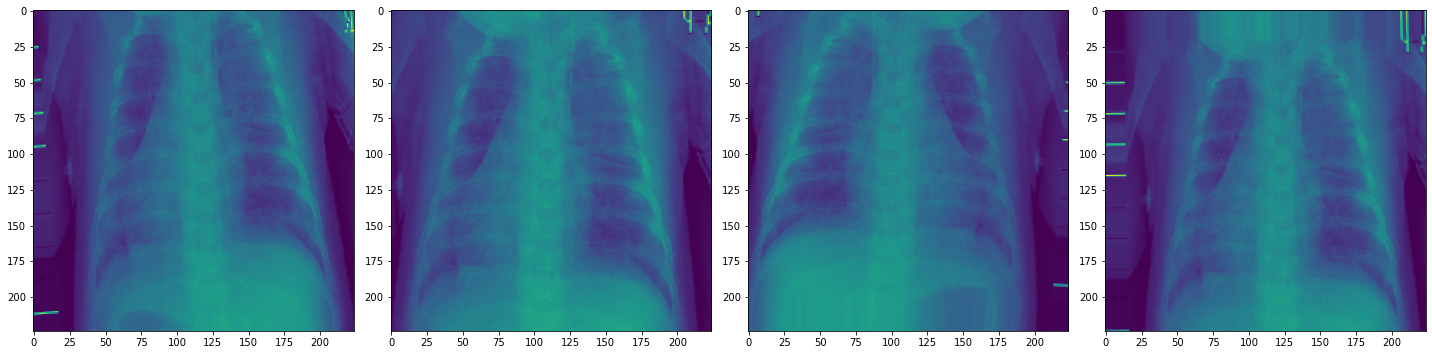

In [15]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 4, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    
    
augmented_images = [np.reshape(train_image_gen[0][0][1],(224,224)) for i in range(4)]
plotImages(augmented_images)

## Model 1: Simple CNN with 5 convolutional layers

The first model we are going to try is a "standard" architecture with 5 convolutional layers alternated with max pooling layers. Since we have only 2 classes (0 = normal, 1 = pneumonia), the last layer is a fully connected with 1 neuron and "sigmoid" activation function.

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,AveragePooling2D,MaxPool2D,BatchNormalization
from sklearn.metrics import classification_report,confusion_matrix

#### We will train for 20 epochs

In [17]:
epochs = 20

We use 2 callbacks: an early stopping to stop the training when the validation loss doesn't improve (to avoid overfitting) and a reduce_learning_rate_on_plateau, which reduces the learning rate when the validation loss has stopped improving.

In [18]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss',patience=4)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1)

#### Now we define our model and we fit to the generator:

In [19]:
model = Sequential()

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = image_shape))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dense(units = 1 , activation = 'sigmoid'))

model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       7

In [20]:
results = model.fit(train_image_gen,epochs=epochs,
                    validation_data=val_image_gen,
                    callbacks=[early_stop,reduce_lr])

Epoch 1/20
294/294 [==============================] - 68s 233ms/step - loss: 0.4623 - accuracy: 0.7514 - val_loss: 0.3798 - val_accuracy: 0.8023
Epoch 2/20
294/294 [==============================] - 66s 224ms/step - loss: 0.3229 - accuracy: 0.8701 - val_loss: 0.3547 - val_accuracy: 0.8042
Epoch 3/20
294/294 [==============================] - 66s 226ms/step - loss: 0.2949 - accuracy: 0.8837 - val_loss: 0.3409 - val_accuracy: 0.8138
Epoch 4/20
294/294 [==============================] - 66s 225ms/step - loss: 0.2657 - accuracy: 0.9018 - val_loss: 0.2648 - val_accuracy: 0.8944
Epoch 5/20
294/294 [==============================] - 66s 225ms/step - loss: 0.2488 - accuracy: 0.9105 - val_loss: 0.2698 - val_accuracy: 0.8772
Epoch 6/20
294/294 [==============================] - 67s 226ms/step - loss: 0.2431 - accuracy: 0.9129 - val_loss: 0.2598 - val_accuracy: 0.8848
Epoch 7/20
294/294 [==============================] - 66s 226ms/step - loss: 0.2263 - accuracy: 0.9225 - val_loss: 0.2776 - val_ac

We define a few functions that will be useful to plot results:

In [29]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()



def make_plots(input_model):
    fig = plt.figure(figsize=(16,4))
    ax = fig.add_subplot(121)
    ax.plot(input_model.history.history["loss"],label='loss')
    ax.plot(input_model.history.history["val_loss"],label='val_loss')
    ax.set_title("validation loss")
    ax.set_xlabel("epochs")
    ax.legend()

    ax2 = fig.add_subplot(122)
    ax2.plot(input_model.history.history["accuracy"],label='accuracy')
    ax2.plot(input_model.history.history["val_accuracy"],label='val_accuracy')
    ax2.set_title("validation accuracy")
    ax2.set_xlabel("epochs")
    ax2.set_ylim(0.6, 1)
    ax2.legend()

    plt.show()

In [30]:
def make_predictions(input_model,image_gen,threshold):

    pred_probabilities = input_model.predict(image_gen)
    predictions = pred_probabilities > threshold
 
    print(classification_report(image_gen.classes,predictions))
    cm = confusion_matrix(image_gen.classes,predictions)
    plot_confusion_matrix(cm,target_names=["normal","pneumonia"],normalize=False)

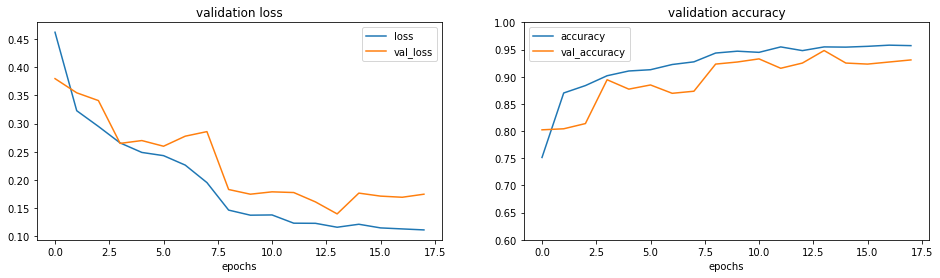

In [23]:
make_plots(model)

              precision    recall  f1-score   support

           0       0.92      0.71      0.80       234
           1       0.85      0.96      0.90       390

    accuracy                           0.87       624
   macro avg       0.88      0.84      0.85       624
weighted avg       0.87      0.87      0.86       624



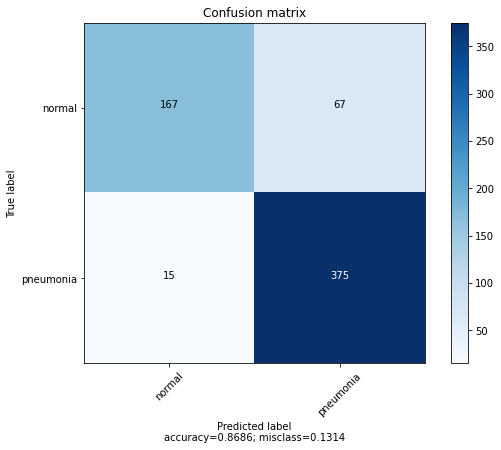

In [52]:
tr = 0.82 #threshold chosen to have at least 96% recall on the 'pneumonia' category (max 15 false negatives)
make_predictions(input_model=model, image_gen=test_image_gen, threshold = tr)

#### Observations:

In medical problems such as this one, it is more important to keep the rate of false negatives as low as possible, even at the cost of increasing the rate of false positives. In other words, we want to have a high recall on the 'pneumonia' category, even if that means having a low recall on the 'normal' category (it is more important to correctly identify all the patients that have pneumonia, while it is less important if we mislabel some healthy patients).

For this reason, here we tuned the value of 'tr' (threshold) in order to have at least a 96% recall on the 'pneumonia' category. 
The precision/recall of this model depends on the value chosen for this threshold. With the chosen working point, we see that we correctly diagnosed 375 patients with pneumonia out of 390, missing only 15 of them, while we still kept a decent recall on the 'normal' category (71%). At the end of the notebook we will see the ROC and precision/recall curves, which are independent from this threshold.

In [41]:
model.save('model_5layers.h5')

In [144]:
#from keras.models import load_model
model_test = load_model('model_5layers.h5')

### Using the model to predict whether a patient has pneumonia or not:

#### We take the X-ray image of a patient with pneumonia:

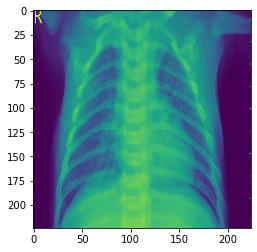

In [164]:
pneumonia_img = pneumonia_3_img/255
pneumonia_img = cv2.resize(pneumonia_img,(224,224))

plt.imshow(pneumonia_img)

In [165]:
pneumonia_img = np.expand_dims(pneumonia_img, axis=0)
pneumonia_img = np.expand_dims(pneumonia_img, axis=-1)

model_test.predict(pneumonia_img)[0][0]

0.9996897

Good! Our model predicted that the patient has 99.97% probability of having pneumonia.

## Model 2: AlexNet architecture

AlexNet is a popular CNN architecture including 8 layers: 5 convolutional layers and 3 fully connected layers. It also features overlapping pooling.

A main difference with respect to the previous model is the kernel size of the first layers, which is much bigger here (11x11 for layer 1 and 5x5 for layer 2, while it was 3x3 for the previous model).

In [55]:
#AlexNet

model = Sequential()

model.add(Conv2D(filters=96, input_shape=image_shape, kernel_size=(11,11), strides=(4,4), 
                 padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))

model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), 
                 padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))

model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), 
                 padding='same', activation='relu'))

model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), 
                 padding='same', activation='relu'))

model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), 
                 padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))


model.add(Flatten())

model.add(Dense(4096, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dense(1000, activation='relu'))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 54, 54, 96)        11712     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 26, 26, 256)       614656    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 12, 12, 384)       885120    
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 12, 12, 384)       1327488   
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 12, 12, 256)      

In [56]:
results = model.fit(train_image_gen,epochs=epochs,
                    validation_data=val_image_gen,
                    callbacks=[early_stop,reduce_lr])

Epoch 1/20
294/294 [==============================] - 70s 237ms/step - loss: 0.5678 - accuracy: 0.7338 - val_loss: 0.4570 - val_accuracy: 0.7409
Epoch 2/20
294/294 [==============================] - 68s 230ms/step - loss: 0.8627 - accuracy: 0.7410 - val_loss: 0.4623 - val_accuracy: 0.7428
Epoch 3/20
294/294 [==============================] - ETA: 0s - loss: 0.4908 - accuracy: 0.7638 ETA: 2s - loss:
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
294/294 [==============================] - 65s 220ms/step - loss: 0.4908 - accuracy: 0.7638 - val_loss: 0.4940 - val_accuracy: 0.7620
Epoch 4/20
294/294 [==============================] - 65s 220ms/step - loss: 0.4239 - accuracy: 0.7949 - val_loss: 0.4640 - val_accuracy: 0.7716
Epoch 5/20
294/294 [==============================] - 65s 220ms/step - loss: 0.3818 - accuracy: 0.8243 - val_loss: 0.4307 - val_accuracy: 0.7908
Epoch 6/20
294/294 [==============================] - 65s 222ms/step - loss: 0.3609 - accurac

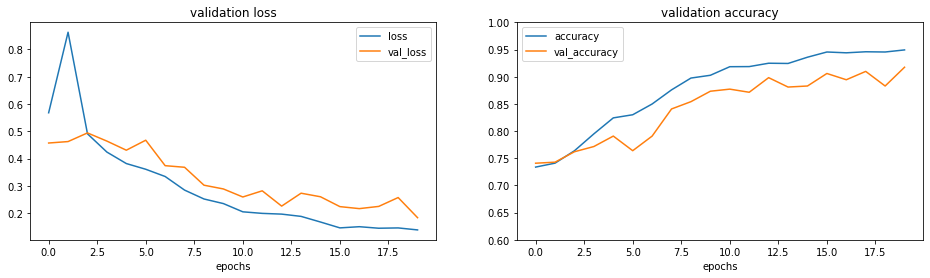

In [57]:
make_plots(model)

              precision    recall  f1-score   support

           0       0.90      0.65      0.75       234
           1       0.82      0.96      0.88       390

    accuracy                           0.84       624
   macro avg       0.86      0.80      0.82       624
weighted avg       0.85      0.84      0.83       624



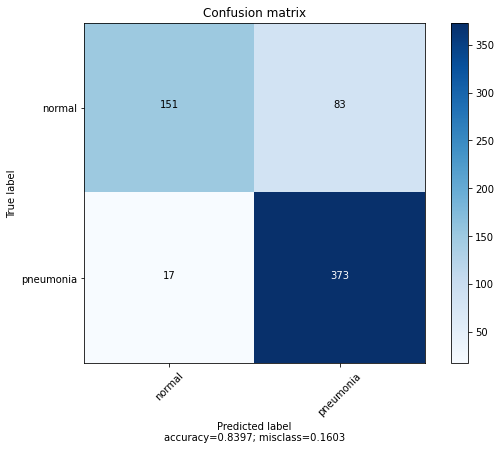

In [62]:
tr = 0.5 #threshold chosen to have at least 96% recall on the 'pneumonia' category
make_predictions(input_model=model, image_gen=test_image_gen, threshold = tr)

#### Observations:

Performance here seem lower - if we keep the threshold such that we have 96% recall on the 'pneumonia' category, we see that the recall on the 'normal' category falls to 65%. We can also see that the rate of false positives and false negatives or both higher than the previous model. 

This may be due to the larger kernel windows in the AlexNet, or perhaps 20 epochs were not enough to reach the plateau. 

In [63]:
model.save('AlexNet.h5')

## Model 3: transfer learning using VGG-16

In the following, we will try to improve the performance by using transfer learning. Transfer learning is the practice of using a pre-trained neural network and apply it to our problem. This way, we don't need to train from scratch all layers of our model, but we will only train fully connected layers added on top of it.

In this section we will use as base model the VGG-16 architecture, an improvement of AlexNet that replaces the large kernel-size filters (11x11 and 5x5) with multiple smaller 3x3 kernel-size filters.
The network was trained on a subset of the famous ImageNet dataset, containing over 1.2 million images divided into 1000 categories. 

Those images don't contain medical images, so the benefits of transfer learning to our problem may be limited; but still, we should be able to observe some improvements.

First, we need to recreate the image data generator to produce color images (VGG-16 accepts color images):

In [65]:
from tensorflow.image import rgb_to_grayscale,grayscale_to_rgb

def gray_to_rgb(image):
    img = rgb_to_grayscale(image)
    img = grayscale_to_rgb(img)
    return img

image_shape = (224,224,3)

In [66]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 16

train_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 10%
                               height_shift_range=0.10, # Shift the pic height by a max of 10%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest', # Fill in missing pixels with the nearest filled value
                               preprocessing_function = gray_to_rgb,
                               validation_split = 0.1
                              )

test_gen = ImageDataGenerator(rescale=1/255,
                              preprocessing_function = gray_to_rgb) # Rescale the image by normalzing it.

In [67]:
train_image_gen = train_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:-1],
                                               batch_size=batch_size,
                                                color_mode='rgb',
                                               class_mode='binary',
                                                subset='training')

val_image_gen = train_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:-1],
                                               batch_size=batch_size,
                                               color_mode='rgb',                                              
                                               class_mode='binary',
                                               subset='validation',
                                              shuffle=False)

test_image_gen = test_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:-1],
                                               batch_size=1,
                                               color_mode='rgb',                                        
                                               class_mode='binary',
                                              shuffle=False)

Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


#### Now we define the model and we train it:

In [68]:
#VGG-16

from keras.applications.vgg16 import VGG16

base_model = VGG16(include_top=False, input_shape=image_shape, pooling='avg')

model=Sequential()
model.add(base_model)

model.add(Flatten())
model.add(Dense(256,activation='relu'))

model.add(Dense(1,activation='sigmoid'))

for layer in base_model.layers:
    layer.trainable = False

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 14,846,273
Trainable params: 131,585
Non-trainable params: 14,714,688
_________________________________________________________________


In [69]:
results = model.fit(train_image_gen,epochs=epochs,
                    validation_data=val_image_gen,
                    callbacks=[early_stop,reduce_lr])

Epoch 1/20
294/294 [==============================] - 119s 406ms/step - loss: 0.2979 - accuracy: 0.8726 - val_loss: 0.2164 - val_accuracy: 0.8964
Epoch 2/20
294/294 [==============================] - 117s 398ms/step - loss: 0.1895 - accuracy: 0.9272 - val_loss: 0.2007 - val_accuracy: 0.9021
Epoch 3/20
294/294 [==============================] - 117s 397ms/step - loss: 0.1712 - accuracy: 0.9333 - val_loss: 0.1776 - val_accuracy: 0.9271
Epoch 4/20
294/294 [==============================] - 117s 398ms/step - loss: 0.1509 - accuracy: 0.9404 - val_loss: 0.1533 - val_accuracy: 0.9386
Epoch 5/20
294/294 [==============================] - 115s 390ms/step - loss: 0.1404 - accuracy: 0.9482 - val_loss: 0.1362 - val_accuracy: 0.9424
Epoch 6/20
294/294 [==============================] - 115s 390ms/step - loss: 0.1347 - accuracy: 0.9504 - val_loss: 0.1401 - val_accuracy: 0.9424
Epoch 7/20
294/294 [==============================] - ETA: 0s - loss: 0.1370 - accuracy: 0.9446
Epoch 00007: ReduceLROnPlate

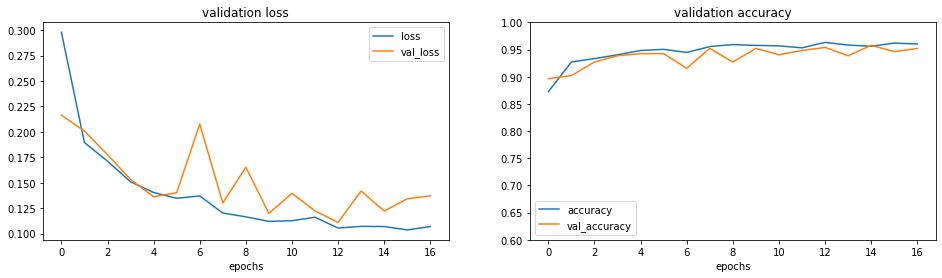

In [70]:
make_plots(model)

              precision    recall  f1-score   support

           0       0.96      0.75      0.84       234
           1       0.87      0.98      0.92       390

    accuracy                           0.90       624
   macro avg       0.92      0.87      0.88       624
weighted avg       0.90      0.90      0.89       624



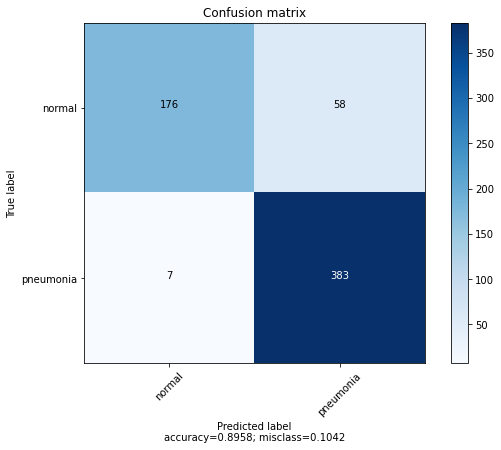

In [78]:
tr = 0.38 #threshold chosen to have at least 96% recall on the 'pneumonia' category
make_predictions(input_model=model, image_gen=test_image_gen, threshold = tr)

#### Observations:

We can already appreciate the benefit of transfer learning even in this problem. In fact, we reduced the number of false negatives to 7 only (98% recall) but keeping a good 75% recall on the 'normal' category as well.

In [74]:
model.save('VGG-16.h5')

## Model 4: transfer learning using DenseNet121

In this last section, we will exploit again transfer learning using a different architecture. We will use the DenseNet121, which alternates convolutional blocks to fully connected layers. This architecture is known to perform well on medical imaging.

#### Let's define and training the model:

In [79]:
#DenseNet121
from keras.applications import DenseNet121

base_model = DenseNet121(include_top=False, input_shape=image_shape)

model=Sequential()
model.add(base_model)

model.add(Flatten())
model.add(Dense(256,activation='relu'))

model.add(Dense(1,activation='sigmoid'))
#model4.add(Dense(2,activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

29089792/29084464 [==============================] - 0s 0us/step
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
flatten_4 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               12845312  
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 257       
Total params: 19,883,073
Trainable params: 12,845,569
Non-trainable params: 7,037,504
_________________________________________________________________


In [80]:
results = model.fit(train_image_gen,epochs=epochs,
                    validation_data=val_image_gen,
                    callbacks=[early_stop,reduce_lr])

Epoch 1/20
294/294 [==============================] - 119s 405ms/step - loss: 0.8095 - accuracy: 0.9180 - val_loss: 0.3783 - val_accuracy: 0.9520
Epoch 2/20
294/294 [==============================] - 115s 392ms/step - loss: 0.3161 - accuracy: 0.9493 - val_loss: 0.3353 - val_accuracy: 0.9328
Epoch 3/20
294/294 [==============================] - 117s 399ms/step - loss: 0.1720 - accuracy: 0.9525 - val_loss: 0.1968 - val_accuracy: 0.9309
Epoch 4/20
294/294 [==============================] - 117s 397ms/step - loss: 0.0974 - accuracy: 0.9649 - val_loss: 0.1046 - val_accuracy: 0.9597
Epoch 5/20
294/294 [==============================] - 115s 392ms/step - loss: 0.0870 - accuracy: 0.9674 - val_loss: 0.0788 - val_accuracy: 0.9693
Epoch 6/20
294/294 [==============================] - 116s 395ms/step - loss: 0.0819 - accuracy: 0.9681 - val_loss: 0.1242 - val_accuracy: 0.9501
Epoch 7/20
294/294 [==============================] - ETA: 0s - loss: 0.0756 - accuracy: 0.9700
Epoch 00007: ReduceLROnPlate

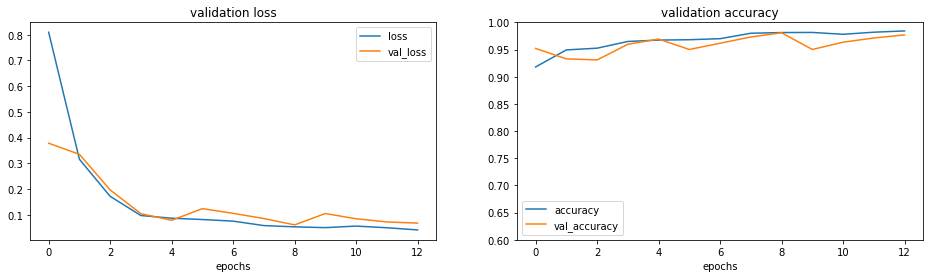

In [81]:
make_plots(model)

              precision    recall  f1-score   support

           0       0.96      0.73      0.83       234
           1       0.86      0.98      0.91       390

    accuracy                           0.88       624
   macro avg       0.91      0.85      0.87       624
weighted avg       0.89      0.88      0.88       624



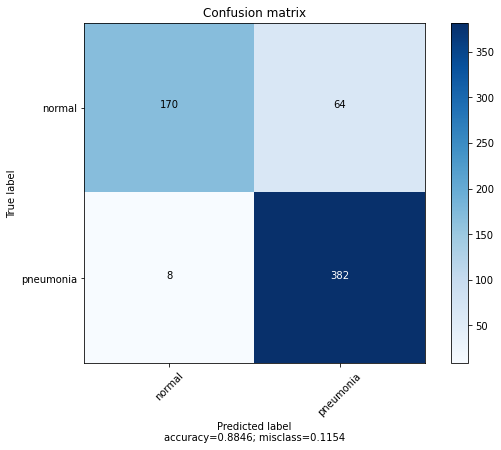

In [84]:
tr = 0.45
make_predictions(input_model=model, image_gen=test_image_gen, threshold = tr)

In [83]:
model.save('DenseNet121.h5')

#### Observations:

From the confusion matrix and the classification report, the performances seem similar to VGG-16, although just a bit worse. However, this may depend on the working point chosen (the treshold 'tr). So, we will now visualize the ROC curves and precision/recall curves of all 4 models to compare them indipendently from the threshold:

## ROC curves and precision/recall curves

Found 624 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


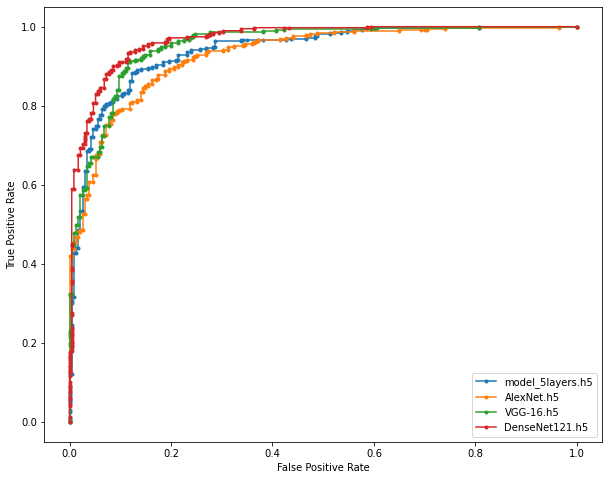

In [105]:
#Plot ROC curves of the 5 models

from sklearn.metrics import roc_curve
from keras.models import load_model

plt.figure(figsize=(10,8))

#for the first 2 models, images are in grayscale:

test_gen = ImageDataGenerator(rescale=1/255) # Rescale the image by normalzing it.

test_image_gen = test_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:-1],
                                               batch_size=1,
                                               color_mode='grayscale',                                        
                                               class_mode='binary',
                                              shuffle=False)

model_to_load = ['model_5layers.h5','AlexNet.h5']

for m in model_to_load:
    model_test = load_model(m)  
    pred_probabilities = model_test.predict(test_image_gen)
    fpr, tpr, _ = roc_curve(test_image_gen.classes, pred_probabilities)
    plt.plot(fpr, tpr, marker='.', label=m)

#For the last 3 models, the images should be in rgb:

test_gen = ImageDataGenerator(rescale=1/255,
                              preprocessing_function = gray_to_rgb) # Rescale the image by normalzing it.

test_image_gen = test_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:-1],
                                               batch_size=1,
                                               color_mode='rgb',                                        
                                               class_mode='binary',
                                              shuffle=False)
    
model_to_load = ['VGG-16.h5','DenseNet121.h5']

for m in model_to_load:
    model_test = load_model(m)  
    pred_probabilities = model_test.predict(test_image_gen)
    fpr, tpr, _ = roc_curve(test_image_gen.classes, pred_probabilities)
    plt.plot(fpr, tpr, marker='.', label=m)
    
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Found 624 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


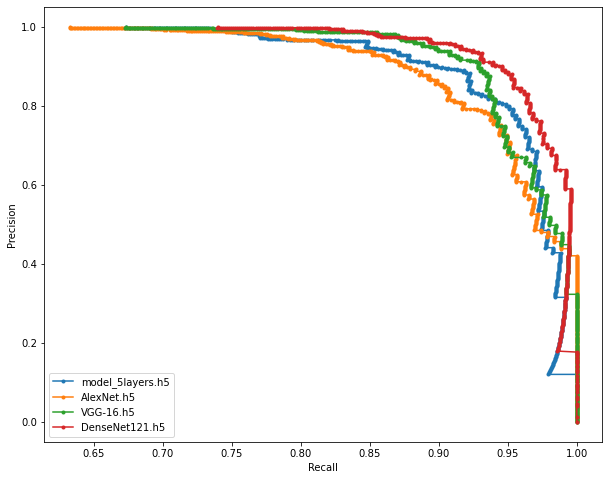

In [106]:
#Plot precision-recall curves of the 5 models

from sklearn.metrics import precision_recall_curve
from keras.models import load_model

plt.figure(figsize=(10,8))

#for the first 2 models, images are in grayscale:

test_gen = ImageDataGenerator(rescale=1/255) # Rescale the image by normalzing it.

test_image_gen = test_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:-1],
                                               batch_size=1,
                                               color_mode='grayscale',                                        
                                               class_mode='binary',
                                              shuffle=False)

model_to_load = ['model_5layers.h5','AlexNet.h5']

for m in model_to_load:
    model_test = load_model(m)  
    pred_probabilities = model_test.predict_proba(test_image_gen)
    prec, rec, _ = precision_recall_curve(test_image_gen.classes, pred_probabilities)
    plt.plot(prec, rec, marker='.', label=m)

#For the last 3 models, the images should be in rgb:

test_gen = ImageDataGenerator(rescale=1/255,
                              preprocessing_function = gray_to_rgb) # Rescale the image by normalzing it.

test_image_gen = test_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:-1],
                                               batch_size=1,
                                               color_mode='rgb',                                        
                                               class_mode='binary',
                                              shuffle=False)
    
model_to_load = ['VGG-16.h5','DenseNet121.h5']

for m in model_to_load:
    model_test = load_model(m)  
    pred_probabilities = model_test.predict(test_image_gen)
    prec, rec, _ = precision_recall_curve(test_image_gen.classes, pred_probabilities)
    plt.plot(prec, rec, marker='.', label=m)
    
    
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## Conclusions:

From these plots, we can see that DenseNet performs better than all the other models, followed by VGG-16. In general, we can see that transfer learning helps in improving the performances in the recognition of patients with pneumonia.